In [1]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import os

from cascid.configs import pad_ufes_cnf,config
from cascid.image import image_preprocessing, image_sampling, HED_segmentation
from cascid.datasets.pad_ufes import database

HED = "../../../../HED/"
HED_RESULTS = HED + "HED_RESULTS/"

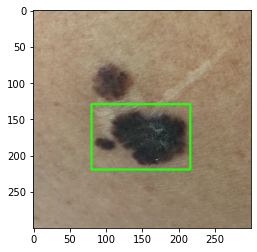

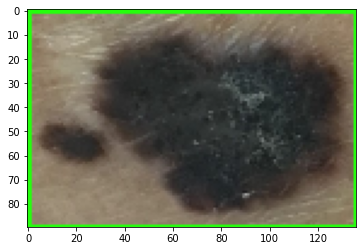

In [45]:
def hed_find_bounding_box(original):
    img = HED_segmentation.apply_HED(original)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    width,height = thresh.shape
    ROI_limit = 20
    size_limit = 20
    lesion_cnts = []
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        # Center restrictions
        if (x > ROI_limit and x < width-ROI_limit) and (y > ROI_limit and y < height-ROI_limit): 
            # Size restrictions
            if (h > size_limit and w > size_limit):
                lesion_cnts.append(((x,y,w,h), w*h))

    if len(lesion_cnts)>0:   
        biggest_cnt = sorted(lesion_cnts, key=lambda c: c[1], reverse=True)[0]
        x,y,w,h = biggest_cnt[0]
        cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
        ROI = original[y:y+h, x:x+w]

        return original, ROI
    
    

original = cv2.imread(HED+"original.png")[:,:,::-1]
original=cv2.resize(original,(300,300))
original, ROI = hed_find_bounding_box(original)
plt.imshow( original)
plt.show()
plt.imshow( ROI)

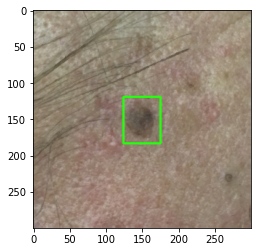

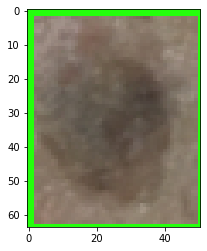

In [73]:
df = database.get_df()
sample_image = str(pad_ufes_cnf.IMAGES_DIR / df.sample(1)["img_id"].iloc[0])
img = cv2.imread(sample_image)[:,:,::-1]
hairless = image_preprocessing.adaptive_hair_removal2(img)
plt.imshow(hairless)

original=cv2.resize(hairless,(300,300))
try:
    original, ROI = hed_find_bounding_box(original)
    plt.imshow( original)
    plt.show()
    plt.imshow( ROI)
except:
    print("No contours found")

